In [7]:
import numpy as np 
import matplotlib.pyplot as plt
import torch as torch
import time
import imageio.v2 as imageio
import tempfile
from IPython.display import Markdown, display, Video
from io import BytesIO
import os

# Automatic Differentiation

A brief informal introduction to automatic differentiation.

A Neural Network is a function implemented using a composition of small functions. The building blocks of Neural Networks are linear projections and non linear activation functions.

How do we compute the derivative a composite function? Using the chain rule. What pytorch, tensorflow or Jax does is computing this derivatives for any function we specify. So our task is:

1. Specify the function
2. Tell pytorch which derivatives do we want to obtain.

## Basic function

Let's start with the function:

$$
y = (x^2 - 4)^3 + 2
$$

The derivative is

$$
\frac{\partial y}{\partial x} = \text{...}
$$

something we usually derive implicitely using our knowledge of basic derivatives, such that the derivative of $f(x)^{n}$ is $f(x)^{n-1} \cdot f'(x)$. 

However, when things get complicate we need to specify a way to obtain complex derivatives, and this is where the chain rule comes into place. For functions $f:\mathbb{R} \rightarrow \mathbb{R}$, we can use the one-dimensional chain rule. 

The idea of the chain rule is to express functions as composition of elementary functions from which the derivative is well known. In our example we could break into a small composition of functions.

$$
y = (x^2 - 4)^3 + 2
$$

could be written as:

$$
\begin{split}
t = \text{...}\\
u = \text{...}\\
z = \text{...}\\
y = \text{...} 
\end{split}
$$

Let's start substituting to show it is equivalent. First subsitute $z = \text{...}$ into $y = \text{...}$, yielding $y = \text{...}$. Now do the same thing and substitute $u = \text{...}$ into $y = \text{...}$, yielding: $y = \text{...}$, and finally subsitute  $t = \text{...}$ into  $y = \text{...}$ yielding $y = ( x^2 - 4)^3 + 2$, which is our original function.

When broken into small functions, we know that the full derivative can be obtained by multiplying the derivatives of the individual functions. In other words:

$$
\frac{\partial y}{\partial x} = \frac{\partial y}{\partial z}\frac{\partial z}{\partial u}\frac{\partial u}{\partial t}\frac{\partial t}{\partial x}
$$

Obviously, the derivative of these small functions are usually easier and well known. In fact, the most important thing is that this gives a principle way of obtaining complex derivatives in a structured and well-ordered way. In fact, in this example when you applied the rule $f(x)^{n}$ is $f(x)^{n-1} \cdot f'(x)$, to obtain $\frac{\partial y}{\partial x}$ directly, you are implicitely applying the chain rule without noticing it.

Let's do it:

$$
\begin{split}
\frac{\partial y}{\partial z} = \text{...} \\
\frac{\partial z}{\partial u} = \text{...} \\
\frac{\partial u}{\partial t} = \text{...} \\
\frac{\partial t}{\partial x} = \text{...} \\
\end{split}
$$

So applying chain rule we have:

$$
\frac{\partial y}{\partial x} = \frac{\partial y}{\partial z}\frac{\partial z}{\partial u}\frac{\partial u}{\partial t}\frac{\partial t}{\partial x} = \text{...}
$$

Note that the last is step is to actually have a derivative which is a function of $x$. In other words, we need to replace the value of $u$ in this example. So using a similar proceedure as above we know the steps to perform are:
1. substitute $t = \text{...}$ into $u = \text{...}$ to yield $u = \text{...}$, finishing the subsitution.
2. If we place this result back into the derivative, subsituting $u$ by this expression that depends on $x$ we yield:

$$
\frac{\partial y}{\partial x} = \frac{\partial y}{\partial z}\frac{\partial z}{\partial u}\frac{\partial u}{\partial t}\frac{\partial t}{\partial x} = \text{...} = 3(x^2 - 4)^2 \cdot 2x
$$

which happily matches the original derivative we obtained. For multivariate functions $f:\mathbb{R}^n \rightarrow \mathbb{R}^m$, things change a bit but that is a story for another chapter.

## Programming derivatives (numpy)

We can code up this example using numpy, where we code up both forward and backward computational graphs. The forward computational graph is refered to the set of operations that provide $y$ from $x$, i.e. the funciton $y(x) = (x^2 - 4)^3 + 2$, while the backward computatinoal graph is the derivative of $y$ w.r.t $x$, i.e. the function $\frac{\partial y}{\partial x} =  3 \cdot (x^2 - 4)^2 \cdot 2 x$. Both computatinoal graphs can be obtained directly or using chain rule.

Implement these computational graphs:

In [8]:
def y_of_x(x: np.array):
    """Evaluates the function $y = (x^2 - 4)^3 + 2$ at point x provided as input arguments."""
    y = (x**2 - 4)**3 + 2
    return y

def y_of_x_from_compositions(x: np.array):
    """Evaluates the function $y = (x^2 - 4)^3 + 2$ at point x provided as input arguments.

    Using the following composition of functions.

    $$
    \begin{split}
    \text{...}
    \end{split}
    $$
    
    """
    t = x**2
    u = t - 4
    z = u**3 
    y = z + 2
    return y


def partial_y_partial_x(x : np.array):
    """Evaluates the derivative of $y = (x^2 - 4)^3 + 2$ at point x provided as input arguments."""
    dy_dx = 3 * (x**2 - 4)**2 * 2 * x   
    return dy_dx

def partial_y_partial_x_chain_rule(x : np.array):
    """Evaluates the derivative of $y = (x^2 - 4)^3 + 2$ at point x provided as input arguments, using chain rule.
    
    To do so we use composition:

    $$
    \begin{split}
    t = \text{...} \\
    u = \text{...} \\
    z = \text{...} \\
    y = \text{...}
    \end{split}
    $$

    using partial derivatives:

    $$
    \begin{split}
    \frac{\partial y}{\partial z} = \text{...}
    \frac{\partial z}{\partial u} = \text{...}
    \frac{\partial u}{\partial t} = \text{...}
    \frac{\partial t}{\partial x} = \text{...}
    \end{split}
    $$
    """
    # we need to go through the function computation, (i.e forward operation) to obtain derivative using chain rule, so that 
    # we can replace u in the derivative.
    t = x**2
    u = t - 4
    z = u**3
    y = z + 2
    
    dt_dx = 2*x
    du_dt = 1
    dz_du = 3*(u**2)
    dy_dz = 1

    
    dy_dx = dy_dz * dz_du * du_dt * dt_dx
    
    return dy_dx

<>:14: SyntaxWarning: invalid escape sequence '\e'
<>:41: SyntaxWarning: invalid escape sequence '\e'
<>:14: SyntaxWarning: invalid escape sequence '\e'
<>:41: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Jaime Cremades\AppData\Local\Temp\ipykernel_23620\4270913005.py:14: SyntaxWarning: invalid escape sequence '\e'
  \end{split}
C:\Users\Jaime Cremades\AppData\Local\Temp\ipykernel_23620\4270913005.py:41: SyntaxWarning: invalid escape sequence '\e'
  \end{split}


Once the above functions are implemented complete the following code:

Text(0.5, 0.98, 'Using Chain Rule')

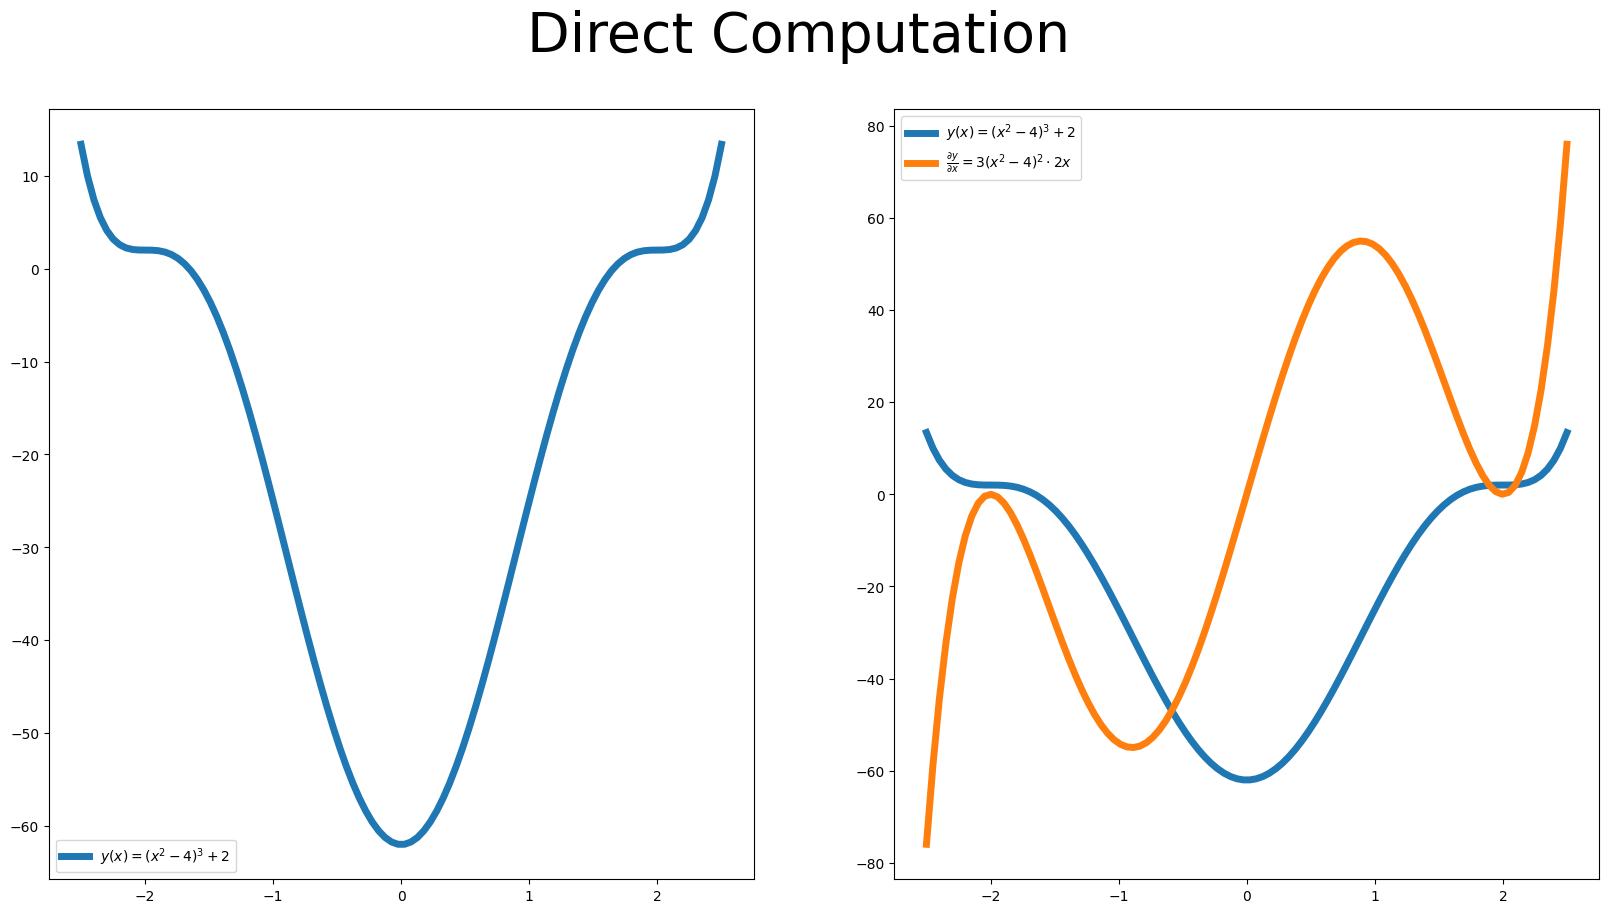

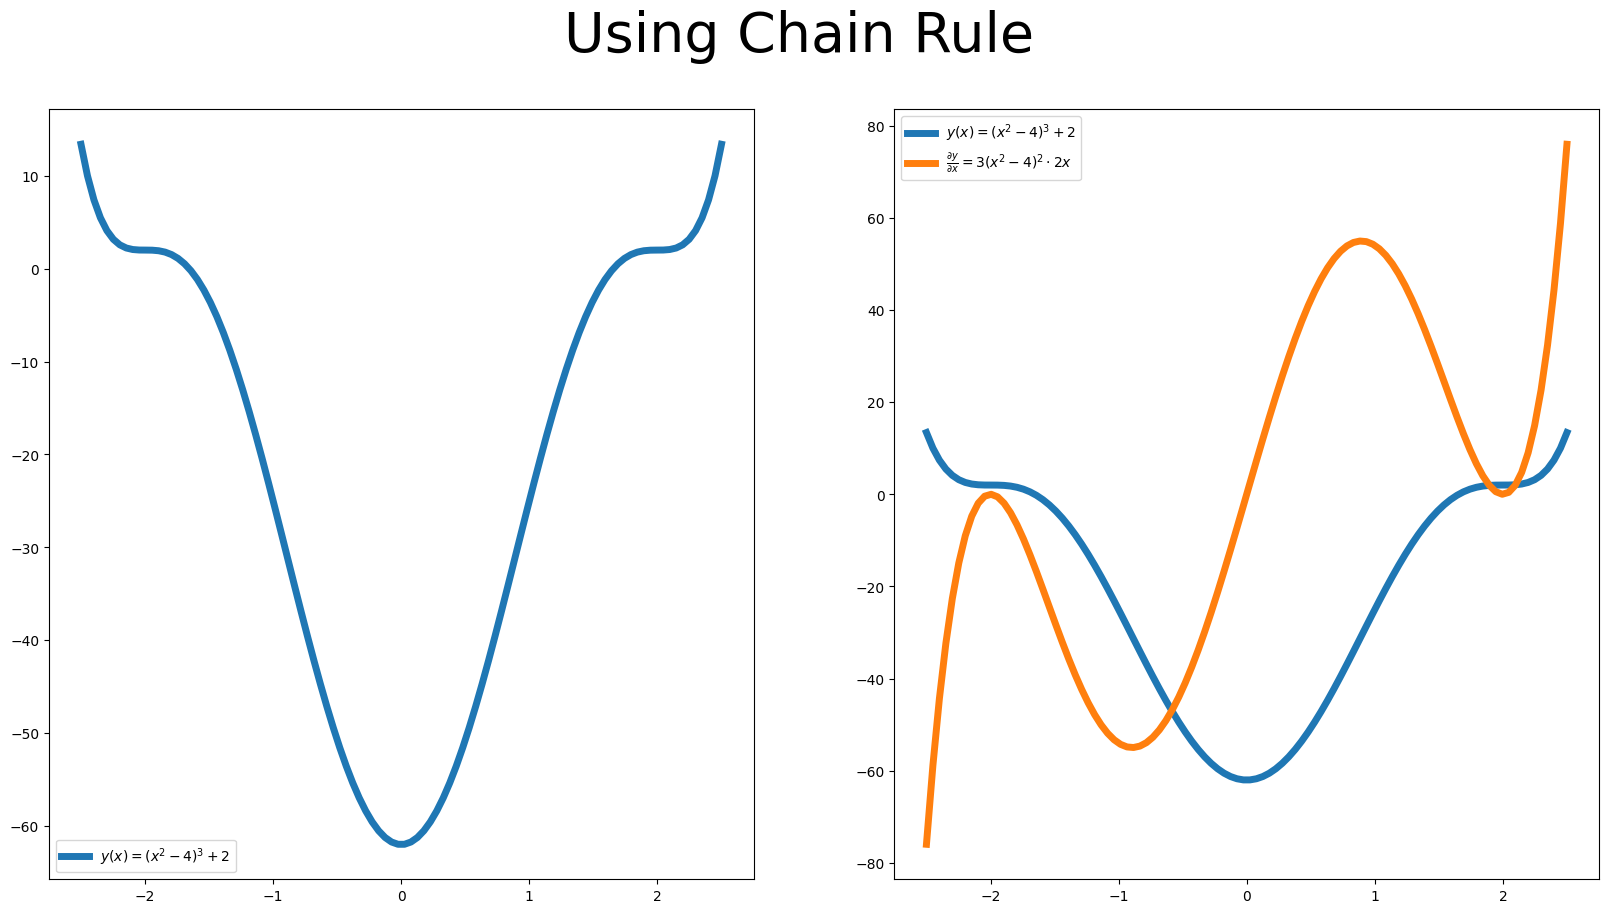

In [9]:
## range over which we want to plot the function
x_min = -2.5
x_max = 2.5
N_points = 100

x = np.linspace(x_min,x_max,N_points)

## Using direct computation
y = y_of_x(x)
dy_dx = partial_y_partial_x(x)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,10))

ax1.plot(x,y, label = '$y(x) = (x^2 - 4)^3 + 2$', linewidth = 5)
ax2.plot(x,y, label = '$y(x) = (x^2 - 4)^3 + 2$', linewidth = 5)
ax2.plot(x,dy_dx, label = r'$\frac{\partial y}{\partial x} = 3(x^2 - 4)^2 \cdot 2x$', linewidth = 5)
ax1.legend()
ax2.legend()
plt.suptitle("Direct Computation", fontsize = 40)

## Using composition of functions and chain rule
y = y_of_x(x)
dy_dx = partial_y_partial_x_chain_rule(x)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,10))

ax1.plot(x,y, label = '$y(x) = (x^2 - 4)^3 + 2$', linewidth = 5)
ax2.plot(x,y, label = '$y(x) = (x^2 - 4)^3 + 2$', linewidth = 5)
ax2.plot(x,dy_dx, label = r'$\frac{\partial y}{\partial x} = 3(x^2 - 4)^2 \cdot 2x$', linewidth = 5)
ax1.legend()
ax2.legend()
plt.suptitle("Using Chain Rule", fontsize = 40)

## Programming derivatives (torch / tensorflow / jax)

What advanced machine learning tools such as torch do to is compute the backward computational graph, from the forward computational graph provide by the user. In other words, tell pytorch which is your target function $y(x)$, through operations, and pytorch will obtain the derivatives automatically, no matter how complex the functions are.

Interestingly, you will notice that the python code is very similar to that used in numpy. The only requirement is to use torch tensors. We also need to tell torch what variables we want the gradient from. 

Complete the following code:

Text(0.5, 0.98, 'Computation with Automatic Differentiation')

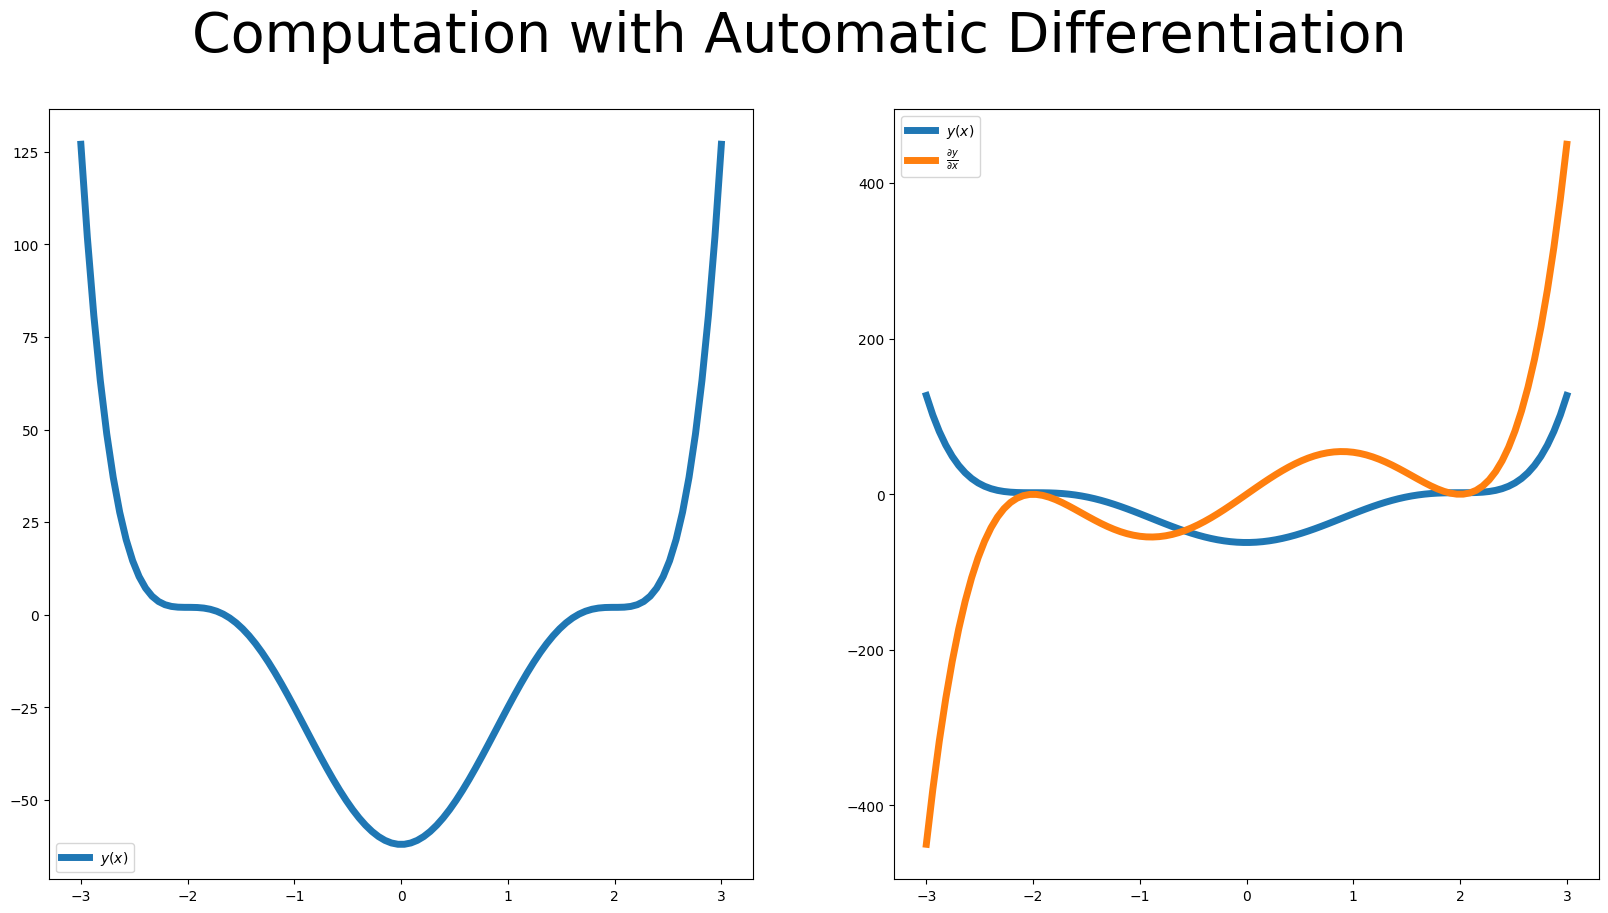

In [10]:
def y_of_x_torch(x : torch.tensor):
    """Evaluates the function $y = (x^2 - 4)^3 + 2$ at point x provided as input arguments."""
    y = y_of_x(x)
    return y

## with pytorch we can create the associated gradient function by just specifying the computational_graph. This tell us
#  pytorch to provide a funciton that obtains the grad of y_of_x(x) wrt x. Forget about vmap and grad, they are advanced 
#  functions you wont use yet but are useful to me to show what I want to show.
dy_dx_fun = torch.func.vmap( torch.func.grad(y_of_x_torch, argnums = 0) )

## range over which we want to plot the function
x_min = -3
x_max = 3
N_points = 100

x = np.linspace(x_min,x_max,N_points)

## conver to torch tensor.
x = torch.from_numpy(x)
## Tell pytorch this tensor requires grad so gradient is saved
x.requires_grad = True

## Forward operation: compute y(x)
y = y_of_x(x)

## Backward operation: evaluate the gradient function
dy_dx = dy_dx_fun(x)

## Convert back to numpy vectors. We use detach since vectors require gradients
x = x.detach().numpy()
y = y.detach().numpy()
dy_dx = dy_dx.detach().numpy()

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,10))

ax1.plot(x,y, label = '$y(x)$', linewidth = 5)
ax2.plot(x,y, label = '$y(x)$', linewidth = 5)
ax2.plot(x,dy_dx, label = r'$\frac{\partial y}{\partial x}$', linewidth = 5)
ax1.legend()
ax2.legend()
plt.suptitle("Computation with Automatic Differentiation", fontsize = 40)

Obviously, the result is the same as when you computed the derivatives manually. The good point is that now you can change the computational graph as you want, and the way we compute the derivative is let to pytorch. Try and change the computational graph specified by function: 

In [11]:
def y_of_x(x : torch.tensor):
    """Evaluates the function $y = (x^2 - 4)^3 + 2$ at point x provided as input arguments."""
    y = (x**2 - 4)**3 + 2
    return y

to whatever function you want. In this example, you have used pytorch to obtain a computational graph for the gradient function. However, for your use case, you will only need the gradient at a single point. This can be easily obtained using the backward() function from pytorch.


To do so, complete the following code

In [12]:
## torch tensor point at which we want the gradient
x = torch.tensor([1.], requires_grad = True)

## evaluate the derivative at that point using torch function
dy_dx = dy_dx_fun(x)

## evaluate the derivative at that point using our numpy function
dy_dx_np = partial_y_partial_x(x.detach().numpy())

## evaluate the derivative at that point using our chain rule numpy function
dy_dx_np_cr = partial_y_partial_x_chain_rule(x.detach().numpy())

## ===========================================
## obtain the derivative at the point directly

# forward through computational graph in pytorch
y = y_of_x_torch(x)
# obtain derivatives wrt to all tensors that require gradient
y.backward()    
# observe the gradient
print('Gradient using the gradient function evaluated at a point ', dy_dx.detach().numpy())
print('Gradient using the gradient function using numpy grad function ', dy_dx_np)
print('Gradient using the gradient function using chain rule numpy grad function ', dy_dx_np_cr)
print('Gradient of a tensor using backward on computational graph ', x.grad.detach().numpy())

Gradient using the gradient function evaluated at a point  [54.]
Gradient using the gradient function using numpy grad function  [54.]
Gradient using the gradient function using chain rule numpy grad function  [54.]
Gradient of a tensor using backward on computational graph  [54.]


## Derivatives w.r.t multiple variables

So far so good, we have seen how to obtain the derivative of $y$ wrt $x$, for functions $f : \mathbb{R} \rightarrow \mathbb{R}$. But what if $y$ depends on two variables $x$ and $z$?. Well this is where the multivariate chain rule steps in and I am not going to provide details. However, as you can expect pytorch is able to obtain the derivatives of any function w.r.t any input variable. Just tell it to do it.

To tell it to do it you need to specify:
1. the computational graph.
2. The variables you want pytorch to compute computational graph from.

Importantly, pytorch will implicitely compute and save gradients for all intermediate variables that come from operations that involve at least one tensor that requires gradient. 

Suppose the function.

$$
\begin{split}
u =  2x + z\\
y = (3-u)^2 + z
\end{split}
$$

Copy paste this code and execute it:

In [13]:
## First case: Compute derivative wrt x and z
x = torch.tensor([2.], requires_grad = True)
z = torch.tensor([3.], requires_grad = True)

# forward: compute y from inputs x and z
u = 2*x +z
y = (3-u)**2 + z

## Backward: compute gradient wrt tensors that require grad. 
#  u also requires grad since it comes from operations involving tensor that do require grad (x and z).
y.backward()

print('u requires grad: ', u.requires_grad)
print('Gradient of y wrt x: ', x.grad)
print('Gradient of y wrt z: ', z.grad)

## =====================================
## Second case: Compute derivative wrt x
x = torch.tensor([2.], requires_grad = True)
z = torch.tensor([3.], requires_grad = False)

# forward: compute y from inputs x and z
u = 2*x +z
y = (3-u)**2 + z

## Backward: compute gradient wrt tensors that require grad. 
#  u also requires grad since it comes from operations involving tensor that do require grad (x and z).
y.backward()

print('u requires grad: ', u.requires_grad)
print('Gradient of y wrt x: ', x.grad)
print('Gradient of y wrt z: ', z.grad)

## =====================================
## Third case: Compute derivative wrt z
x = torch.tensor([2.], requires_grad = False)
z = torch.tensor([3.], requires_grad = True)

# forward: compute y from inputs x and z
u = 2*x +z
y = (3-u)**2 + z

## Backward: compute gradient wrt tensors that require grad. 
#  u also requires grad since it comes from operations involving tensor that do require grad (x and z).
y.backward()

print('u requires grad: ', u.requires_grad)
print('Gradient of y wrt x: ', x.grad)
print('Gradient of y wrt z: ', z.grad)

u requires grad:  True
Gradient of y wrt x:  tensor([16.])
Gradient of y wrt z:  tensor([9.])
u requires grad:  True
Gradient of y wrt x:  tensor([16.])
Gradient of y wrt z:  None
u requires grad:  True
Gradient of y wrt x:  None
Gradient of y wrt z:  tensor([9.])


## 1. Regresion $f:\mathbb{R} \rightarrow \mathbb{R}$

Let's come back to our initial problem and try and solve it using pytorch instead of numpy. If you solved the previous assignment using pytorch, then it should be really straightforward to solve gradient descent now modifying your previous code. 

Our goal now is not to provide fancy pictures to understand things, just to see how pytorch makes our life easier.

Our data was:

$$
(x_1,t_1) = (0,0.2)\\
(x_2,t_2) = (1,0.5)\\
(x_3,t_3) = (2,2.8)
$$

which should be wrapped into torch tensors as:

In [14]:
# input to our model. Represents time in seconds
x_data = torch.from_numpy(np.array([0,1,2]).reshape(3,1))
# outputs associated to each input. Represents cantidad de lluvia in mm^3
t_data = torch.from_numpy(np.array([0.2,0.5,2.8]).reshape(3,1))

### 1.1 Plot data

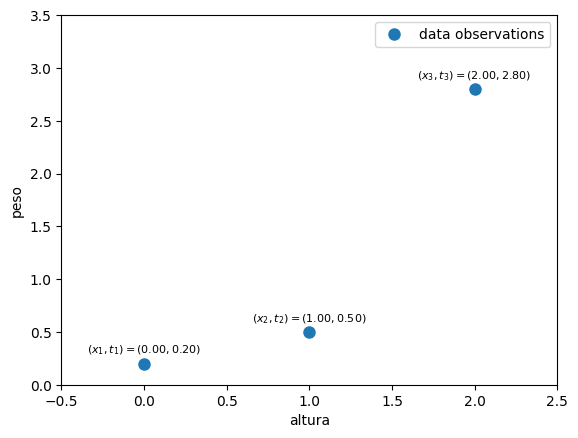

In [15]:
# input to our model. Represents time in seconds
x_data = torch.from_numpy((x_data.detach().numpy()).reshape(3,1)).float()
# outputs associated to each input. Represents cantidad de lluvia in mm^3
t_data = torch.from_numpy((t_data.detach().numpy()).reshape(3,1)).float()

## display
plt.plot(x_data,t_data,'o', markersize = 8, label = 'data observations')
for i in range(len(x_data)):
    plt.text(x_data[i], t_data[i] + 0.1, f"$(x_{i+1},t_{i+1})=({float(x_data[i]):.2f},{float(t_data[i]):.2f})$", fontsize=8, ha="center")  # Etiqueta sobre el punto
plt.xlabel('altura')
plt.ylabel('peso')
plt.ylim([0,3.5])
plt.xlim([-0.5,2.5])
plt.legend()

### 1.2 Initialization

The first step in a machine learning model is model initialization. For linear regression we need to initialize the the weight $w$ and bias $b$.

Since for backpropagation we want gradient descent to update these parameters, we need to tell pytorch that these parameters should require gradient computation.

Initialize the variables $w$ and $b$ with values around $0$, and wrap them in a list of tuples, such that:

```python
parameters = [(w,b)]
```

You are free to use the data structure you want, this is just a suggestion.

In [16]:
w = torch.from_numpy(np.ones([1,1])).float()
w.requires_grad = True
b = torch.from_numpy(np.zeros([1])).float()
b.requires_grad = True
parameters = [(w,b)]

### 1.3 Computational graph creation

We just need to tell pytorch what is the computational graph to differentiate. This is easy. In linear regresion we just have:

$$
y = w\cdot x+ b
$$

The step of computing the output given the input is usually known in the literature as the *forward* operation. Let's create a function that receives the *parameters* variable and the input $x$ and returns the predictions $y$. The inputs $x$ should be feed as a matrix with rows being the sample and columns the feature. So in this case we will have a matrix of size $(N,1)$ where $N$ represents the total number of samples.

In [17]:
def forward(X,parameters):
    for w,b in parameters:
        y = X @ w + b
    return y

### 1.4 Loss function computation

We want to optimize a loss funciton w.r.t the parameters of the model. To do so we need to compute the loss funciton, which is the element we will tell pytorch to get the derivative w.r.t. the parameters.

This step also belongs to the *forward* operation.

Most of the loss functions are provided in the pytorch library.

Implement four loss functions: square difference, absolute diference, square diference using pytorch library (https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), and absolute difference using pytorch library (https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html).

Our goal is just to compare that custom loss function creations gives exactly the same result as using pytorch.

Implement four functions that given $t$ and $y$ return the loss.

In [18]:
def loss_function_square(t,y):
        L = torch.sum((t - y) ** 2)
        return L
    
def loss_function_absolute(t,y):
        L = torch.sum(torch.abs(t-y))
        return L

def loss_function_square_torch(t,y):
        mse = nn.MSELoss(reduction='sum')  # creamos el objeto de pérdida
        L = mse(y, t)                      # lo llamamos con (pred, target)
        return L
    
def loss_function_absolute_torch(t,y):
        mae = nn.L1Loss(reduction='sum')
        L = mae(y,t)
        return L

### 1.5 Implement gradient descent

You now have all the ingredients to compute gradient descent easily, where you will see where is the power of pytorch. Just specify computational graph, and let it do the rest. 

Your goal know is to implement an iterative algorithm that implements gradient descent using the functionalities above.

One important thing to consider is that pytorch saves the accumulated gradient into `variable.grad` as you know. Between each gradient update we need to reset the gradient after updating the parametres. This can be done by executing `variable.grad.zero_()`

As a reminder, the steps are:

1. Initialize the model
2. Forward
3. Loss computation
4. Backward
5. Parameter update
6. Reseting gradients on the parameters

Implement two plots, one plot should show the current model learnt, and the other a plot that shows the loss over the course of learning.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from io import BytesIO
import imageio
from IPython import display
import os

# ==================== CONFIGURACIÓN ESTABLE ====================
loss_type = 'sse'  # Cambia a: 'sse', 'sse_pytorch', 'abs', 'abs_pytorch'
epochs = 100
lr = 0.1  # Reducido de 0.5 a 0.1 para mayor estabilidad

# ==================== DATOS Y MODELO ====================
x_data = torch.tensor([[0.5], [1.0], [1.5], [2.0]], dtype=torch.float32)
t_data = torch.tensor([[0.8], [1.4], [1.8], [2.5]], dtype=torch.float32)

def forward(x, w, b):
    return w * x + b

# ==================== INICIALIZACIÓN ====================
w = torch.tensor([[0.5]], requires_grad=True)  # Inicialización más pequeña
b = torch.tensor([0.0], requires_grad=True)

# Validación
if loss_type not in ["sse", "sse_pytorch", "abs", "abs_pytorch"]:
    raise ValueError("Invalid loss type")

# ==================== VIDEO SETUP ====================
video_filename = "training_video.mp4"
writer = imageio.get_writer(video_filename, format="FFMPEG", mode="I", fps=15, codec="libx264")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
x_range = torch.linspace(-0.5, 2.5, 100).view(-1, 1)

loss_acc = []
grad_norms = []  # Para monitorear gradientes

# ==================== TRAINING LOOP ====================
for e in range(epochs):
    # Forward pass
    y_pred = forward(x_data, w, b)
    
    # Loss computation
    if loss_type == "sse":
        L = torch.sum((t_data - y_pred) ** 2)
    elif loss_type == "abs":
        L = torch.sum(torch.abs(t_data - y_pred))
    elif loss_type == "sse_pytorch":
        mse = nn.MSELoss(reduction='sum')
        L = mse(y_pred, t_data)
    elif loss_type == "abs_pytorch":
        mae = nn.L1Loss(reduction='sum')
        L = mae(y_pred, t_data)
    
    # Backward pass
    L.backward()
    
    # ========== SEGURIDAD: CLIPPING DE GRADIENTES ==========
    torch.nn.utils.clip_grad_norm_([w, b], max_norm=1.0)
    
    loss_acc.append(L.item())
    
    # Parameter update
    with torch.no_grad():
        w -= lr * w.grad
        b -= lr * b.grad
        w.grad.zero_()
        b.grad.zero_()
    
    # ==================== PLOTTING ====================
    ax1.cla()
    ax2.cla()
    
    # Plot 1: Datos y modelo
    ax1.plot(x_data.numpy(), t_data.numpy(), 'o', label='Observaciones', markersize=8)
    ax1.plot(x_range.numpy(), forward(x_range, w, b).detach().numpy(), 
             label=f'Modelo (época {e+1})', color='red', linewidth=2)
    ax1.set_xlabel('Altura (m)', fontsize=12)
    ax1.set_ylabel('Peso (kg)', fontsize=12)
    ax1.set_ylim([0, 3.5])
    ax1.set_xlim([-0.5, 2.5])
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Curva de pérdida (¡CORREGIDO Y SEGURO!)
    ax2.plot(range(1, e+2), loss_acc, 'b-', linewidth=2)
    ax2.set_xlim([0, epochs])
    
    # ====== CÁLCULO SEGURO DEL LÍMITE Y ======
    if loss_acc:
        max_loss_val = max(loss_acc)
        # Verificar si es finito (no NaN, no Inf)
        if np.isfinite(max_loss_val):
            upper_limit = max_loss_val * 1.1
        else:
            print(f"⚠️  Advertencia: Loss no finita en época {e+1}. Usando límite por defecto.")
            upper_limit = 10.0  # Valor por defecto seguro
    else:
        upper_limit = 1.0
    
    ax2.set_ylim([0, upper_limit])
    ax2.set_xlabel('Épocas', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_title(f'Loss: {loss_type} | Época {e+1}/{epochs}', fontsize=13)
    ax2.grid(True, alpha=0.3)
    
    # Guardar frame
    fig.canvas.draw()
    buf = BytesIO()
    fig.savefig(buf, format='png', dpi=100, bbox_inches='tight')
    buf.seek(0)
    frame = imageio.imread(buf)
    writer.append_data(frame)

# ==================== FINALIZAR ====================
writer.close()
plt.close()

# Mostrar video
display.display(display.Video(data=video_filename, embed=True))

# Opcional: eliminar archivo
# os.remove(video_filename)

C:\Users\Jaime Cremades\AppData\Local\Temp\ipykernel_23620\2557694407.py:113: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frame = imageio.imread(buf)
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1018, 479) to (1024, 480) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


## 2.  Regression from $f:\mathbb{R} \rightarrow [0,1]$

Let's repeat this process but now using our regression problem to the unit cube. Let's repeat the process of regresion but using our two loss functions, named Binary Cross Entropy and Brier score. This time, we will just use pytorch function wrappers. You could use custom implementation if you want, however in a real world scenario if available then use always pytorch implementations.

Our data was:

$$
\begin{split}
(x_1,t_1) &= (-0.13459237,0)\\
(x_2,t_2) &= (-3.3015387,0)\\
(x_3,t_3) &= (0.74481176,0)\\
(x_4,t_4) &= (2.62434536,1)\\
(x_5,t_5) &= (0.38824359,1)\\
(x_6,t_6) &= (0.47182825,1)\\
(x_7,t_7) &= (-0.07296862,1)\\
\end{split}
$$
